How to apply PCA to segment data without using any classifiers

# PCA

We're applying PCA step by step this week.

We will first analyze the data to see why we should be interested in applying PCA. Our data comes (again) from Kaggle. This time is tiny glass classification problem. The number of labels for $y$ is 6, so we have a _multinomial_ supervised classification problem. The number of dimensions is not very high (9), but we will use PCA to see it that help us to better classify our data. Actually we will try to perform the glass classification using ONLY rules and PCA... let's see if that is possible.

Remember that PCA is NOT a classification method, BUT a technique. It is completely UNSUPERVISED, which means that when you apply PCA the algorithm doesn't take into account what is the value of the target variable.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import warnings

warnings.filterwarnings("ignore")

# All these options are optional.
%load_ext lab_black
pd.set_option("display.max_columns", 1000)
pd.set_option("max_seq_items", 1000)
pd.set_option("display.width", 1000)
np.set_printoptions(threshold=np.inf)


def resize():
    plt.figure(figsize=(8, 5))


def show():
    plt.tight_layout()
    plt.show()

As usual, read the data into a pandas DataFrame and scale everything.

In [2]:
data = pd.read_csv("glass.csv")
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Set what are our features, and what is our target feature

In [3]:
# Set a variable (features) with the names of all the features BUT the target variable.
target = "Type"
feature_names = list(set(data.columns) - set([target]))
print(f"The list of columns that represent features is:\n{feature_names}")
print(f"So, we have {len(feature_names)} dimensions in our feature vectors.")
print(
    f"""
Labels ({len(data[target].unique())}) in our problem are: {data[target].unique()}
"""
)

scaler = RobustScaler().fit(data[feature_names])
data[feature_names] = scaler.transform(data[feature_names]).round(4)

print()
data.head()

The list of columns that represent features is:
['K', 'RI', 'Ca', 'Al', 'Na', 'Mg', 'Ba', 'Fe', 'Si']
So, we have 9 dimensions in our feature vectors.

Labels (6) in our problem are: [1 2 3 5 6 7]




,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.2638,0.3706,0.6801,-0.5909,-1.2508,-1.0154,0.1609,0.0,0.0,1
1,-0.0266,0.6431,0.0808,0.0000,-0.0743,-0.1538,-0.8257,0.0,0.0,1
2,-0.5693,0.2507,0.0471,0.4091,0.2477,-0.3385,-0.8794,0.0,0.0,1
3,-0.0076,-0.0981,0.1414,-0.1591,-0.2229,0.0308,-0.4075,0.0,0.0,1
4,-0.0987,-0.0327,0.0943,-0.2727,0.3591,-0.0103,-0.5684,0.0,0.0,1


Let's plot the distribution of the different classes ($y$) to see if they're easily separable.

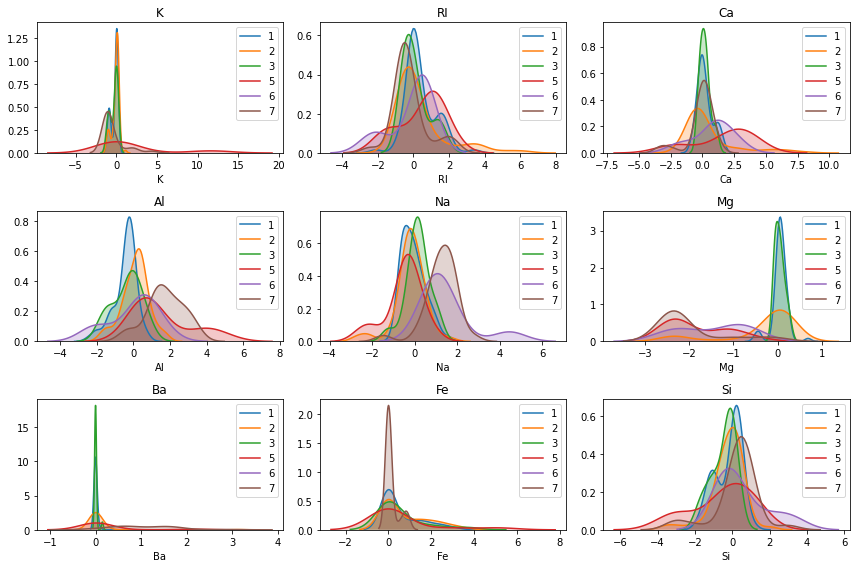

In [4]:
categories = data[target].unique()
category_series = data[target]

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(12, 8)

for subplot, feature in enumerate(feature_names):
    x, y = int(subplot / 3), subplot % 3
    for value in data[target].unique():
        sns.distplot(
            data[feature][category_series == value],
            hist=False,
            kde=True,
            kde_kws={"shade": True},
            label=str(value),
            ax=axs[x, y],
        )
    axs[x, y].set_title(feature)

show()

We can identify some peak values, but none of the characteristics in the plots above suggest that we can easily separate any of the classes using the distribution of their mineral composition.

And now let's plot what is the mean amount of each mineral in the composition of each glass type, to see if we can distinguish any of them.

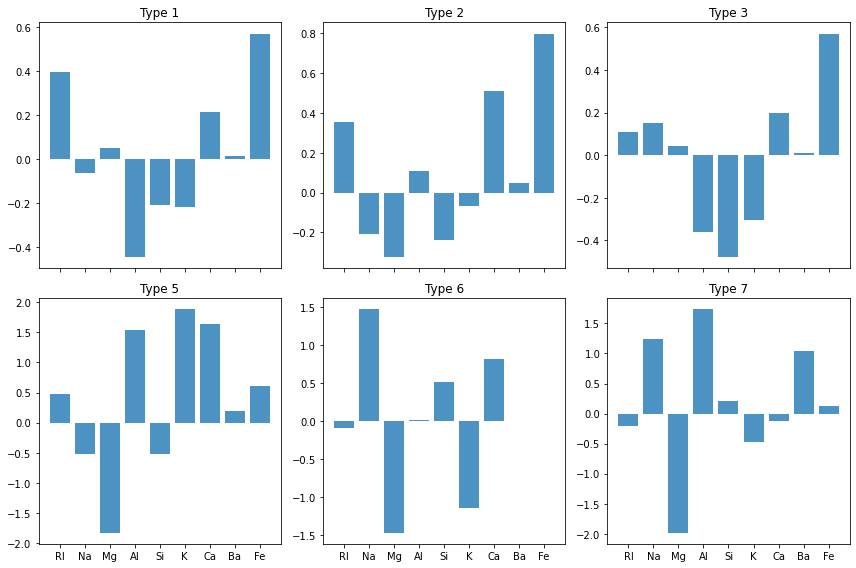

In [5]:
mineral_amount = {}
for glass_type in categories:
    type_df = data[data[target] == glass_type].describe()
    mineral_amount[glass_type] = type_df.values[1][:9]
minerals = list(type_df.columns[:9])

num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, sharex=True)
fig.set_size_inches(12, 8)

for subplot, glass_type in enumerate(categories):
    x, y = int(subplot / num_cols), subplot % num_cols
    axs[x, y].bar(
        range(mineral_amount[glass_type].shape[0]),
        mineral_amount[glass_type],
        alpha=0.8,
    )
    axs[x, y].set_xticks(range(len(minerals)), minerals)
    axs[x, y].set_title(f"Type {glass_type}")

plt.xticks(range(len(minerals)), minerals)
show()

We can see that our classifier can easily separate "Type 6" glasses from the rest, as they don't have any amount of "Ba" or "Fe". So, our problem becomes a 5-labels classification problem: Types 1, 2, 3, 5 and 7.

## PCA

Let's fit a PCA to our problem, just to see how it works. But this is just for those of you who can't wait to see it in action. We will have to rebuild the PCA afterwards.

In [6]:
pca = PCA(n_components=2, random_state=1)
features_transformed = pca.fit_transform(data[feature_names])

We're specifying that we want only the first two components (out of the possible 9 that we can get). We are also calling the `fit()` and `tranform()` methods at once, but we could do it in two steps. The result of this call is the original set of features projected in to a 2-dimensional space. That's why the result has a shape of only two columns.

Let's examine the principal components, and the percentage of variance explained by them. Looks like using only two components is not enough.

In [7]:
print(f"Principal components shape: {pca.components_.shape}\n")
print(f"     PC1      PC2\n---------------------")
for i in range(pca.components_.shape[1]):
    print(f"{i:>2d}: {pca.components_[0][i]:+0.4f}, {pca.components_[1][i]:+0.4f}")

print(f"\nVariance explained: {np.round(pca.explained_variance_ratio_, 2)}")

Principal components shape: (2, 9)

     PC1      PC2
---------------------
 0: -0.3332, +0.5993
 1: +0.5197, +0.1022
 2: +0.7100, +0.2841
 3: -0.2617, +0.5341
 4: -0.0887, -0.0856
 5: -0.1106, -0.4394
 6: -0.0273, +0.1191
 7: +0.0841, +0.0184
 8: -0.1356, -0.2225

Variance explained: [0.38 0.19]


### Play with transformed features

Now let's build a dataframe with all our features projected into the new 2-D space defined by the PCA (the transformed features obtained in the previous step). The result is a new dataset with only 2 new features that we can use to determine if our new problem can be easily solved. 

The only trick I'm using in the code below is that I'm attaching an additional column to the trasnformed features, with the label of the dataset (the **Type**, or glass type). That will help me to use these projected features to perform classification with them, instead of the original ones, which are in a higher dimensional space.

In [8]:
pca_df = pd.DataFrame(data=features_transformed)
pca_df = pd.concat([pca_df, data[target]], axis=1)
pca_df.columns = ["TF1", "TF2", "Type"]
print("Showing the first rows of the projected features\n")
pca_df.head()

Showing the first rows of the projected features



,TF1,TF2,Type
0,0.814048,-1.263673,1
1,-1.116141,-0.865608,1
2,-1.486964,-0.851749,1
3,-0.750054,-0.649281,1
4,-0.947706,-0.904000,1


The exact way of producing this result ($X_T$) on your own is:

$$ X_T = (X - \overline{X}) \times PC $$

where $PC$ are the principal components, and $\overline{X}$ is the mean of each feature. The way to try this yourself is:

```python
X = data[feature_names]
X_mean = pca.mean_

XT = (X - X_mean).dot(pca.components_.T)
```



# Practice

## Exercise 1a

We haven't removed from our original dataset, those rows (samples) corresponding to the "Type 6" glass. Build a new dataset that will remove those rows. Our problem will be easier to solve and won't present any sample from that type (6).

Hint: [https://stackoverflow.com/a/45489976/892904](https://stackoverflow.com/a/45489976/892904)

In [9]:
data_1a = data[data[target] != 6]
data_1a[target].unique()

array([1, 2, 3, 5, 7])

## Exercise 1b

Actually, there's something else we must ALWAYS explore, which is checking for outliers. Display boxplots to decide on outliers and create a new dataframe without them, if that is the case.

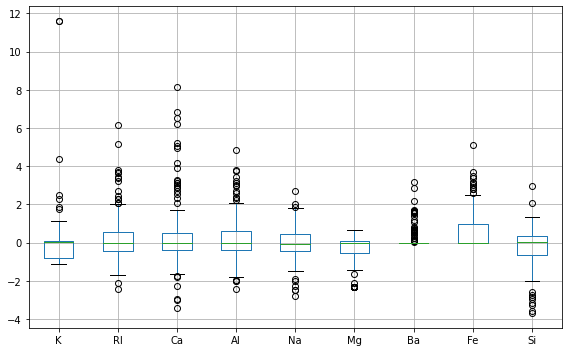

In [10]:
resize()
data_1a[feature_names].boxplot()
show()

Well, seems to me that we could safely consider some of the entries as outliers (take a look at "K" or "Ba". 

In [11]:
X, y = data_1a[feature_names].values, data_1a[target].values
print("Before removing outliers:", X.shape, y.shape)

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X)

mask = yhat != -1
X, y = X[mask, :], y[mask]
print("After removing outliers:", X.shape, y.shape)

Before removing outliers: (205, 9) (205,)
After removing outliers: (184, 9) (184,)


Here, I'm simply buiding a DataFrame (`data_1b`) with the arrays that resulted from the previous step.

data_1b shape: (184, 10)


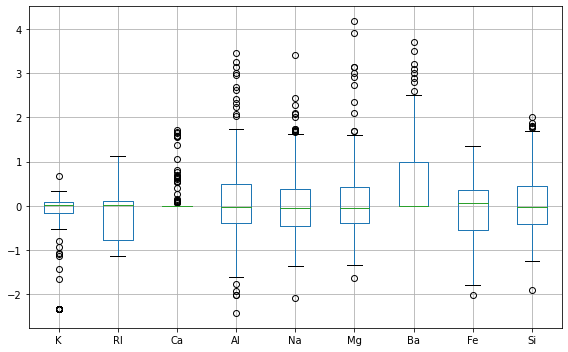

In [12]:
data_1b = pd.DataFrame(X, columns=data_1a[feature_names].columns)
data_1b[target] = pd.Series(y)
data_1b.columns = data_1a.columns
print(f"data_1b shape: {data_1b.shape}")

resize()
data_1b[feature_names].boxplot()
show()

## Exercise 2

Make a scatter plot of the new data resulting from previous step, using a different color for each point, depending on the value of the column "Type". So, all points corresponding the the same glass type have the same color. ¿Is the problem solvable now?

Hint: [https://stackoverflow.com/a/32740814/892904](https://stackoverflow.com/a/32740814/892904)

TO do this, we must re-compute PCA and make the transformation of the original features into the new 2D space defined by the two principal components.

In [13]:
pca = PCA(n_components=2, random_state=1)
data_1b_transformed = pca.fit_transform(data_1b[feature_names])
print(f"Principal Components shape: {pca.components_.shape}")
print(f"Transformed Features shape: {data_1b_transformed.shape}")

Principal Components shape: (2, 9)
Transformed Features shape: (184, 2)


Let's plot it to see how the new data gathers in different correlated groups. We will check if that helps to perform classification.

I define a simple method to plot the scatter for me, since I'm gonna use it repeatedly. I will pass this method, x and y coordinates, labels, and all the variables needed to plot (fig, ax and title).

In [14]:
def scatter(X1, X2, y, fig, ax, title):
    colors = ["red", "green", "grey", "purple", "blue"]
    colormap = cmap = ListedColormap(colors)

    for glass_type in y.unique():
        i = np.where(y == glass_type)
        ax.scatter(X1[i], X2[i], label=f"Type {glass_type}", alpha=0.7)

    ax.set_title(title)
    ax.legend(loc="best")

And now, call the scatter with the first (X[0]) and sencond (X[1]) principal components.

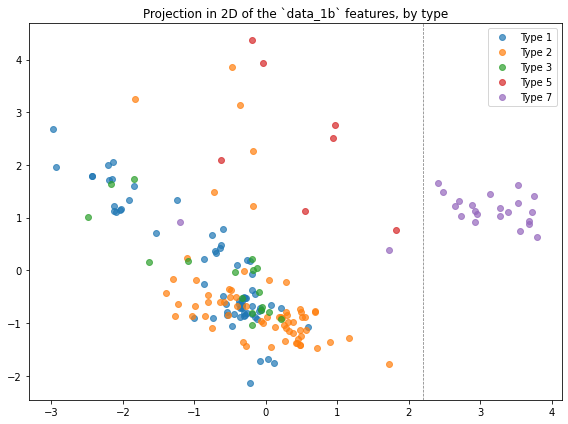

In [15]:
X = data_1b_transformed.T
y = data_1b[target]

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
scatter(X[0], X[1], y, fig, ax, "Projection in 2D of the `data_1b` features, by type")
ax.axvline(2.2, linestyle="--", c="grey", linewidth=0.75)
show()

From the 2 PC scenario, we can only classify or separate Type 7.

Suggestion: Use more than two components and play with combinations of them to separate Type 1, 2, 3 and 5.

## Exercise 3

At this point you should be able to separate **at least** two glass types without building any classifier at all, just by applying a rule on "Type 6" and detecting some other type from what you see in the previous step. What else can you do?

Hint 1: Try to represent the distribution of Types in the new principal components
Hint 2: Try generating PCA with more than 2 principal components, at this stage, to see if they produce better class separation.

First of all, separate class 7, as we know how to identify it.

In [16]:
data_2 = data_1b[data_1b[target] != 7]
data_2[target].unique()

array([1, 2, 3, 5])

Build another PCA, this time with more components, to see if it works fine to separate 1, 2, 3 and 5.

In [17]:
pca = PCA(n_components=3, random_state=1)
data_2_transformed = pca.fit_transform(data_2[feature_names])
print(
    f"""
    Variance explained: {np.round(pca.explained_variance_ratio_, 2)},
    Sum: {np.round(pca.explained_variance_ratio_.sum(), 2)}"""
)


    Variance explained: [0.44 0.22 0.19],
    Sum: 0.85


Now, plot all the combinations of the four principal components that we've just obtained.

X shape: (3, 161)


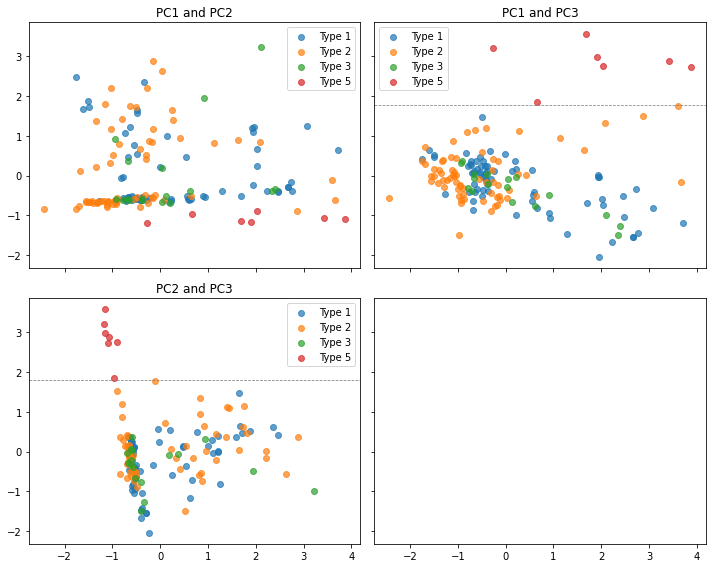

In [18]:
X = data_2_transformed.T
y = data_2[target]
print(f"X shape: {X.shape}")

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(10, 8)
scatter(X[0], X[1], y, fig, axs[0, 0], "PC1 and PC2")
scatter(X[0], X[2], y, fig, axs[0, 1], "PC1 and PC3")
axs[0, 1].axhline(1.79, linestyle="--", c="grey", linewidth=0.75)
scatter(X[1], X[2], y, fig, axs[1, 0], "PC2 and PC3")
axs[1, 0].axhline(1.79, linestyle="--", c="grey", linewidth=0.75)
show()

Finally we see how we can use PC1+PC3 or PC2+PC3 of the combinations to separate Type-5 samples, using this PCA projection.

To better separate 1, 2 and 3 we could continue this process, removing "Type-5" from the dataset and trying again (please, do it!), or we could try something different to achieve that goal. In this case, I don't see PCA working very well with those 3 classes, which means that we should try SVD (Singular Vector Decomposition) or a pure classifier (my bet is for trees).

## Summary

We start with a 6 classes problem and we can partially solve it by:

  1. Examine the amount of "Ba" and "Fe". If it is zero, then the glass is "Type-6"
  2. Apply a PCA to the remaining classes and using the two first PCs extract "Type-7" using the coordinates of the projected features.
  3. Apply another PCA to the remaining classes, and using any of the projections separate "Type-5" glass type.
  4. Explore other methods to separate 1, 2 and 3 glass-type classes.